# Generating Various Types of Graphs by Proximity
This notebook illustrates how to generate and visualize different spatial graph types based on proximity metrics (KNN, Delaunay, Gilbert, Waxman) using City2Graph, OSMnx, and NetworkX.

## Overview
This notebook covers:
- Setting up the environment and importing libraries
- Retrieving points of interest around a location
- Defining helper functions for node extraction and plotting
- Generating and visualizing KNN, Delaunay, Gilbert, and Waxman graphs interactively

## 1. Setup and Environment

In [1]:
import warnings

import contextily as ctx
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from IPython.display import HTML
from matplotlib import animation

import city2graph

warnings.filterwarnings("ignore")

## 2. Retrieve Points of Interest
Fetch restaurant POIs around Shibuya, Tokyo using OSMnx and filter to nodes only. Also, streets network is obtained for calculating network distances.

In [2]:
poi_tags = {
    "amenity": [
        "restaurant"]}

#poi_gdf = ox.features_from_place("Shibuya, Tokyo, Japan", poi_tags)
poi_gdf = ox.features_from_point(
    (35.658514, 139.70133),  # Tokyo Tower coordinates
    tags=poi_tags,
    dist=1000,  # Search radius in meters
    )

# Filter to include only nodes, not ways and relations
poi_gdf = poi_gdf[poi_gdf.index.get_level_values("element") == "node"]

# Reproject to a projected CRS for accurate centroids
poi_gdf = poi_gdf.to_crs(epsg=6677)

In [3]:
segments_G = ox.graph_from_point(
    (35.658514, 139.70133),  # Tokyo Tower coordinates
    dist=1000,  # Search radius in meters
    )

segments_gdf = ox.graph_to_gdfs(segments_G, nodes=False, edges=True)

## 3. Define Helper Functions
Define functions to extract node positions and plot graphs with degree centrality and optional basemap.

In [4]:
def get_node_positions(gdf):
    """Extract node positions from GeoDataFrame."""
    node_positions = {}
    for id, geom in gdf["geometry"].items():
        if geom.geom_type == "Point":
            node_positions[id] = (geom.x, geom.y)
        else:
            centroid = geom.centroid
            node_positions[id] = (centroid.x, centroid.y)
    return node_positions

def plot_graph(graph, title, node_positions, node_color="skyblue", edge_color="gray",
               add_basemap=False, crs=None):
    """Plot a network graph with color-coded nodes based on degree centrality."""
    # Compute degree centrality for node coloring
    node_degrees = dict(graph.degree())
    node_colors = [node_degrees.get(node, 0) for node in graph.nodes()]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Set equal aspect ratio to maintain map proportions
    ax.set_aspect("equal")

    # Plot the edges with better color
    nx.draw_networkx_edges(graph, pos=node_positions,
                          edge_color="grey",
                          alpha=0.5,
                          width=0.5,
                          ax=ax)

    # Plot the POIs with beautiful color scheme
    nodes = nx.draw_networkx_nodes(graph, pos=node_positions,
                          node_size=30,
                          node_color=node_colors,
                          cmap=plt.cm.plasma,
                          alpha=0.9,
                          linewidths=0.5,
                          ax=ax)

    # Add basemap if requested - with no buffer/margin
    if add_basemap and crs:
        ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)

    # Set exact limits based on node positions to avoid any buffer
    node_xs = [pos[0] for pos in node_positions.values()]
    node_ys = [pos[1] for pos in node_positions.values()]
    ax.set_xlim(min(node_xs), max(node_xs))
    ax.set_ylim(min(node_ys), max(node_ys))

    # Add a colorbar with better styling
    cbar = plt.colorbar(nodes, ax=ax, label="Degree Centrality", shrink=0.8)
    cbar.ax.tick_params(labelsize=10)

    plt.title(title, fontsize=14, fontweight="bold", pad=20)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

node_positions = get_node_positions(poi_gdf)


# Utility functions for animations
def compute_bounds(node_positions):
    """Return x_min, x_max, y_min, y_max for given node positions."""
    xs = [x for x, y in node_positions.values()]
    ys = [y for x, y in node_positions.values()]
    return min(xs), max(xs), min(ys), max(ys)

def animate_frame(i, poi_gdf, graph_func, param_list, title_fmt, ax, bounds):
    """Generic animation frame function for proximity graphs."""
    node_positions = get_node_positions(poi_gdf)
    x_min, x_max, y_min, y_max = bounds
    params = param_list[i]
    graph = graph_func(poi_gdf, **params)
    ax.clear()
    node_degrees = dict(graph.degree())
    node_colors = [node_degrees.get(n,0) for n in graph.nodes()]
    nx.draw_networkx_edges(graph, pos=node_positions, edge_color="gray", alpha=0.5, width=0.5, ax=ax)
    nx.draw_networkx_nodes(graph, pos=node_positions, node_size=30, node_color=node_colors, cmap=plt.cm.plasma, alpha=0.9, linewidths=0.5, ax=ax)
    if poi_gdf.crs:
        ctx.add_basemap(ax, crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect("equal")
    ax.set_title(title_fmt.format(**params), fontsize=14, fontweight="bold", pad=20)
    ax.axis("off")
    return ax

def animate_and_save(poi_gdf, graph_func, param_list, title_fmt, save_path, interval=200, fps=5):
    """Create and save animation for proximity graphs."""
    node_positions = get_node_positions(poi_gdf)
    bounds = compute_bounds(node_positions)
    fig, ax = plt.subplots(figsize=(12, 10))

    def animate(i):
        return animate_frame(i, poi_gdf, graph_func, param_list, title_fmt, ax, bounds)

    ani = animation.FuncAnimation(fig, animate, frames=len(param_list), interval=interval, repeat=True)
    writer = animation.FFMpegWriter(fps=fps)
    ani.save(save_path, writer=writer)
    return ani

## 4. K-Nearest Neighbors (KNN) Graph
Create an interactive slider to plot KNN graphs for varying $k$ values. You can specify the distance metric from `"manhattan"`, `"euclidean"`,  and `"network"`. If you use network distance, you need to set the GeoDataFrame of network. You can save the output as GeoDataFrame or nx.Graph.

In [5]:
knn_l1 = city2graph.knn_graph(poi_gdf,
                              distance_metric="manhattan",
                              network_gdf=segments_gdf.to_crs(epsg=6677),
                              as_gdf=True)

knn_l2 = city2graph.knn_graph(poi_gdf,
                              distance_metric="euclidean",
                              network_gdf=segments_gdf.to_crs(epsg=6677),
                              as_gdf=True)

knn_net = city2graph.knn_graph(poi_gdf,
                               k=10,
                               distance_metric="network",
                               network_gdf=segments_gdf.to_crs(epsg=6677),
                               as_gdf=True)

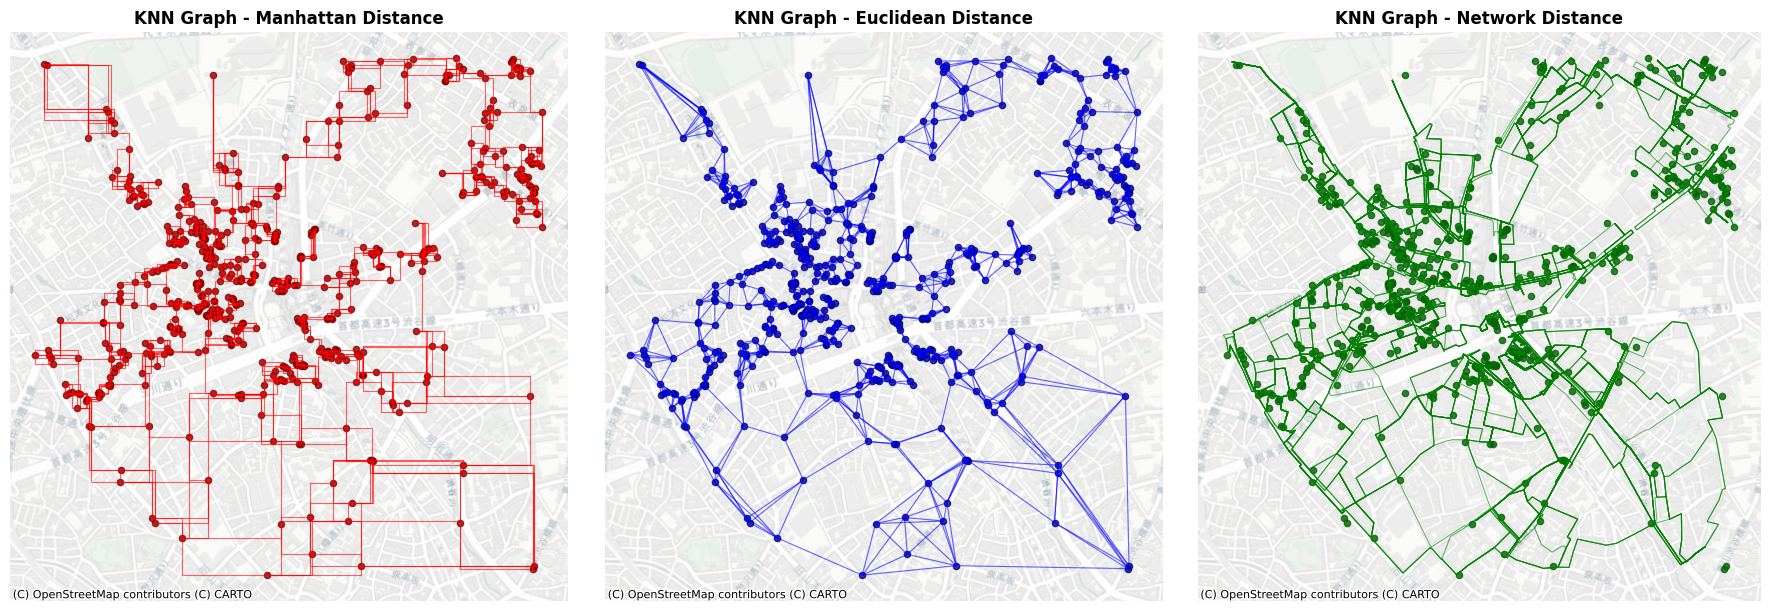

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Manhattan distance KNN graph
knn_l1.plot(ax=axes[0], color='red', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[0], color='darkred', markersize=20, alpha=0.8)
ctx.add_basemap(axes[0], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[0].set_title('KNN Graph - Manhattan Distance', fontsize=12, fontweight='bold')
axes[0].set_aspect('equal')
axes[0].axis('off')

# Plot Euclidean distance KNN graph
knn_l2.plot(ax=axes[1], color='blue', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[1], color='darkblue', markersize=20, alpha=0.8)
ctx.add_basemap(axes[1], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[1].set_title('KNN Graph - Euclidean Distance', fontsize=12, fontweight='bold')
axes[1].set_aspect('equal')
axes[1].axis('off')

# Plot Network distance KNN graph
knn_net.plot(ax=axes[2], color='green', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[2], color='darkgreen', markersize=20, alpha=0.8)
ctx.add_basemap(axes[2], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[2].set_title('KNN Graph - Network Distance', fontsize=12, fontweight='bold')
axes[2].set_aspect('equal')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [7]:
plt.close("all")  # Close existing figures
plt.ioff()

def plot_knn_graph(poi_gdf, node_positions, k_value):
    """Interactive plotting function for KNN graphs."""
    knn_graph = city2graph.knn_graph(poi_gdf, k=k_value)
    plot_graph(
    knn_graph,
    f"KNN Graph (k={k_value}) of Restaurants in Shibuya, Tokyo",
    node_positions,
    edge_color="gray",
    add_basemap=True,
    crs=poi_gdf.crs,
    )

max_k = 100
param_list = [{"k": k} for k in range(1, max_k + 1)]
ani_knn = animate_and_save(
    poi_gdf,
    city2graph.knn_graph,
    param_list,
    "KNN Graph (k={k}) of Restaurants in Shibuya, Tokyo",
    "../_static/knn_graph.mp4",
    interval=500,
    fps=5,
)

plt.close("all")  # Close existing figures

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x1000 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ../_static/knn_graph.mp4
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x1000 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ../_static/knn_graph.mp4


In [8]:
HTML("""
<video controls style="width: 100%; max-width: 800px; height: auto;">
    <source src="../_static/knn_graph.mp4" type="video/mp4">
</video>
""")

## 5. Delaunay Graph
Generate and plot a Delaunay triangulation graph of the POIs.

In [9]:
del_l1 = city2graph.delaunay_graph(poi_gdf,
                                   distance_metric="manhattan",
                                   as_gdf=True)

del_l2 = city2graph.delaunay_graph(poi_gdf,
                                   distance_metric="euclidean",
                                   as_gdf=True)

del_net = city2graph.delaunay_graph(poi_gdf,
                                    distance_metric="network",
                                    network_gdf=segments_gdf.to_crs(epsg=6677),
                                    as_gdf=True)

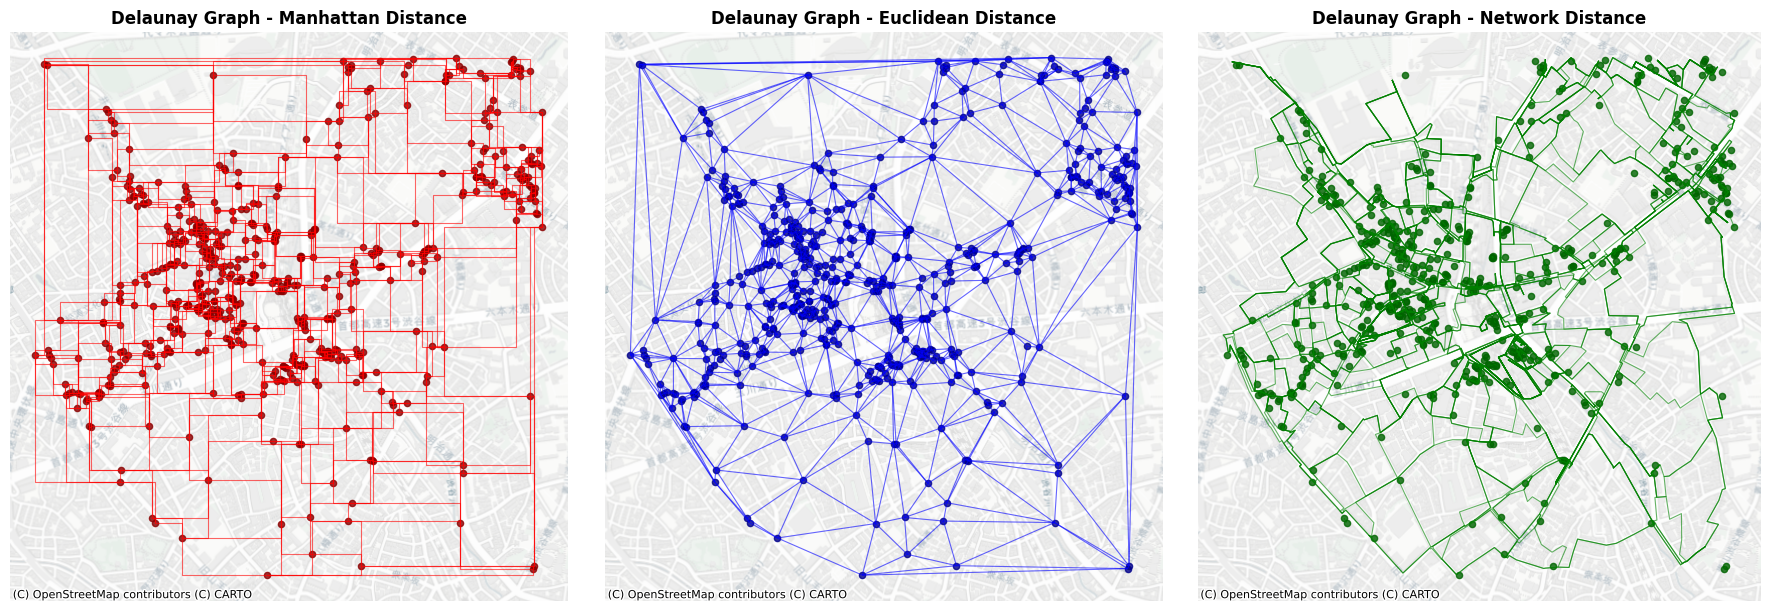

In [10]:
plt.ion()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Manhattan distance Delaunay graph
del_l1.plot(ax=axes[0], color='red', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[0], color='darkred', markersize=20, alpha=0.8)
ctx.add_basemap(axes[0], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[0].set_title('Delaunay Graph - Manhattan Distance', fontsize=12, fontweight='bold')
axes[0].set_aspect('equal')
axes[0].axis('off')

# Plot Euclidean distance Delaunay graph
del_l2.plot(ax=axes[1], color='blue', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[1], color='darkblue', markersize=20, alpha=0.8)
ctx.add_basemap(axes[1], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[1].set_title('Delaunay Graph - Euclidean Distance', fontsize=12, fontweight='bold')
axes[1].set_aspect('equal')
axes[1].axis('off')

# Plot Network distance Delaunay graph
del_net.plot(ax=axes[2], color='green', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[2], color='darkgreen', markersize=20, alpha=0.8)
ctx.add_basemap(axes[2], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[2].set_title('Delaunay Graph - Network Distance', fontsize=12, fontweight='bold')
axes[2].set_aspect('equal')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [11]:
delaunay_graph_gdf = city2graph.delaunay_graph(poi_gdf, as_gdf=True)

# Use the existing plot_gdf_graph function with basemap
plot_gdf_graph(poi_gdf,
               delaunay_graph_gdf,
               "Delaunay Graph of Restaurants in Shibuya, Tokyo",
               add_basemap=True)


NameError: name 'plot_gdf_graph' is not defined

## 6. Gilbert Graph (Hard Threshold Model)
Gilbert Graph is a deterministic model to generate edges based on the Euclidean distance. Given a parameter $r$ as radious, neighbours are connected if they are within the radious from a node.

In [ ]:
gil_l1 = city2graph.gilbert_graph(poi_gdf,
                                  distance_metric="manhattan",
                                  radius=100,
                                  as_gdf=True)

gil_l2 = city2graph.gilbert_graph(poi_gdf,
                                  distance_metric="euclidean",
                                  radius=100,
                                  as_gdf=True)

gil_net = city2graph.gilbert_graph(poi_gdf,
                                   distance_metric="network",
                                   radius=100,
                                   network_gdf=segments_gdf.to_crs(epsg=6677),
                                   as_gdf=True)


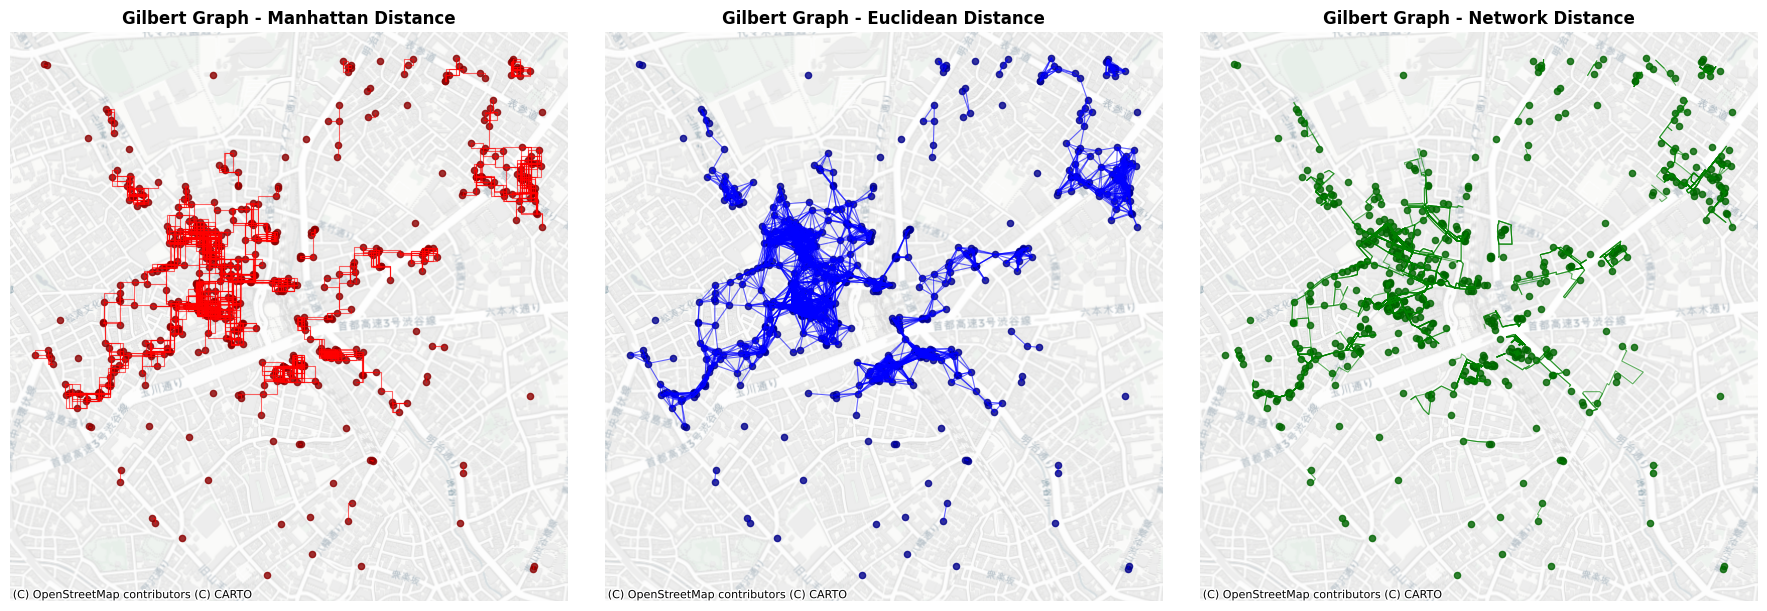

In [ ]:
plt.ion()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Manhattan distance Gilbert graph
gil_l1.plot(ax=axes[0], color='red', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[0], color='darkred', markersize=20, alpha=0.8)
ctx.add_basemap(axes[0], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[0].set_title('Gilbert Graph - Manhattan Distance', fontsize=12, fontweight='bold')
axes[0].set_aspect('equal')
axes[0].axis('off')

# Plot Euclidean distance Gilbert graph
gil_l2.plot(ax=axes[1], color='blue', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[1], color='darkblue', markersize=20, alpha=0.8)
ctx.add_basemap(axes[1], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[1].set_title('Gilbert Graph - Euclidean Distance', fontsize=12, fontweight='bold')
axes[1].set_aspect('equal')
axes[1].axis('off')

# Plot Network distance Gilbert graph
gil_net.plot(ax=axes[2], color='green', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[2], color='darkgreen', markersize=20, alpha=0.8)
ctx.add_basemap(axes[2], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[2].set_title('Gilbert Graph - Network Distance', fontsize=12, fontweight='bold')
axes[2].set_aspect('equal')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.ioff()

def plot_gilbert_graph(poi_gdf, node_positions, r_value):
    """Interactive plotting function for Gilbert graphs."""
    gilbert_graph = city2graph.gilbert_graph(poi_gdf, radius=r_value)
    plot_graph(
    gilbert_graph,
    f"Gilbert Graph (radius={r_value}m) of Restaurants in Shibuya, Tokyo",
    node_positions,
    edge_color="gray",
    add_basemap=True,
    crs=poi_gdf.crs,
    )

max_r = 500  # max radius in meters
frames = 100
param_list = [{"radius": (i + 1) * (max_r / frames)} for i in range(frames)]
ani_gilbert = animate_and_save(
    poi_gdf,
    city2graph.gilbert_graph,
    param_list,
    "Gilbert Graph (radius={radius:.0f}m) of Restaurants in Shibuya, Tokyo",
    "../_static/gilbert_graph.mp4",
    interval=200,
    fps=5,
)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x1000 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ../_static/gilbert_graph.mp4


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x1000', '-pix_fmt', 'rgba', '-framerate', '5', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '../_static/gilbert_graph.mp4']' returned non-zero exit status 255.

In [ ]:
HTML("""
<video controls style="width: 100%; max-width: 800px; height: auto;">
    <source src="../_static/gilbert_graph.mp4" type="video/mp4">
</video>
""")

## 7. Waxman Graph (Soft Random Geometry Model)
Interactive sliders to generate Waxman graphs with adjustable r0 and beta parameters. The probability of connection follows below: $$H_{ij} = \beta e^{-\frac{d_{ij}}{r_0}}$$

where $d_{ij}$ is the Euclidean distance between node $i$ an $j$; $r_0$ is the maximum distance between nodes; and $\beta$ denotes the scaling parameter.

In [ ]:
wax_l1 = city2graph.waxman_graph(poi_gdf,
                                 distance_metric="manhattan",
                                 r0=100,
                                 beta=0.5,
                                 as_gdf=True)

wax_l2 = city2graph.waxman_graph(poi_gdf,
                                 distance_metric="euclidean",
                                 r0=100,
                                 beta=0.5,
                                 as_gdf=True)

wax_net = city2graph.waxman_graph(poi_gdf,
                                  distance_metric="network",
                                  r0=100,
                                  beta=0.5,
                                  network_gdf=segments_gdf.to_crs(epsg=6677),
                                  as_gdf=True)

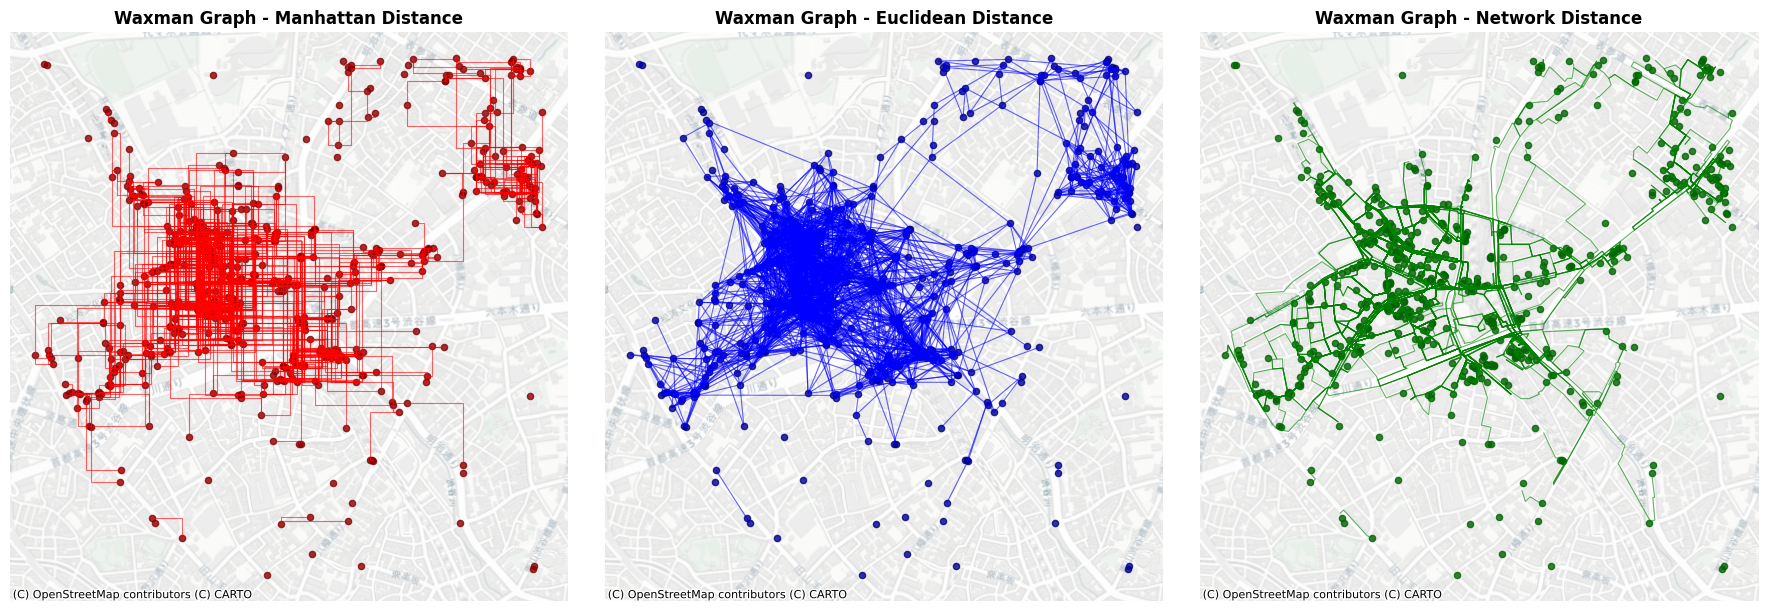

In [ ]:
plt.ion()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Manhattan distance Waxman graph
wax_l1.plot(ax=axes[0], color='red', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[0], color='darkred', markersize=20, alpha=0.8)
ctx.add_basemap(axes[0], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[0].set_title('Waxman Graph - Manhattan Distance', fontsize=12, fontweight='bold')
axes[0].set_aspect('equal')
axes[0].axis('off')

# Plot Euclidean distance Waxman graph
wax_l2.plot(ax=axes[1], color='blue', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[1], color='darkblue', markersize=20, alpha=0.8)
ctx.add_basemap(axes[1], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[1].set_title('Waxman Graph - Euclidean Distance', fontsize=12, fontweight='bold')
axes[1].set_aspect('equal')
axes[1].axis('off')

# Plot Network distance Waxman graph
wax_net.plot(ax=axes[2], color='green', alpha=0.6, linewidth=0.8)
poi_gdf.plot(ax=axes[2], color='darkgreen', markersize=20, alpha=0.8)
ctx.add_basemap(axes[2], crs=poi_gdf.crs, source=ctx.providers.CartoDB.Positron)
axes[2].set_title('Waxman Graph - Network Distance', fontsize=12, fontweight='bold')
axes[2].set_aspect('equal')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plt.ioff()

# Corrected parameter ranges
r0_values = list(range(0, 255, 5))  # Every 1 from 1 to 250
beta_values = [0.01, 0.1, 0.5, 1.0]  # 0.01, 0.1, 0.5, 1.0

param_list = [{"r0": r0, "beta": beta} for beta in beta_values for r0 in r0_values]
ani_waxman = animate_and_save(
    poi_gdf,
    city2graph.waxman_graph,
    param_list,
    "Waxman Graph (r0={r0}, beta={beta:.2f}) of Restaurants in Shibuya, Tokyo",
    "../_static/waxman_graph.mp4",
    interval=200,
    fps=5,
)


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x1000 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ../_static/waxman_graph.mp4


In [11]:
HTML("""
<video controls style="width: 100%; max-width: 800px; height: auto;">
    <source src="../_static/waxman_graph.mp4" type="video/mp4">
</video>
""")